## Necessary Imports

In [1]:
%matplotlib notebook
import pandas as pd, numpy as np, random
import matplotlib.pyplot as plt, matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns

## Reading Data

We have 6 difference species worth of data. Here we are reading in and analyzing just one. 

In [2]:
# Read csv into data frame. 
df = pd.read_csv('data/gene_level/DC10_GL_clust-smry.csv')

# Keep only relevant columns in the data frame.
df = df[['sum_meanTPM_Ti','sum_meanTPM_Tii','sum_meanTPM_Tiii','sum_meanTPM_Tiv']]

# Remove rows that have missing values and/or infinite values. 
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Convert everything to doubles. 
df = df.astype('double')

## Raw Data Plot

Each gene has expression levels given at 4 different time points. We take each one of those time points and plot them. Since we can only plot in 3 dimensions, the last time point is represented as color. 

<IPython.core.display.Javascript object>


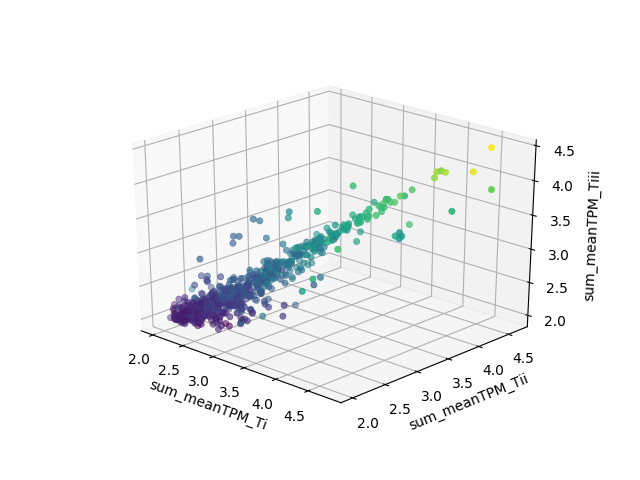

In [4]:
# Most of the data points are less than 200. I am only plotting ones larger than 200 to make the code run faster.
x = df['sum_meanTPM_Ti'].where(df['sum_meanTPM_Ti'] > 100)
y = df['sum_meanTPM_Tii'].where(df['sum_meanTPM_Tii'] > 100)
z = df['sum_meanTPM_Tiii'].where(df['sum_meanTPM_Tiii'] > 100)
r = df['sum_meanTPM_Tiv'].where(df['sum_meanTPM_Tiv'] > 100)

# Supress massive values by taking log. 
# Values may be massive becuase of large expression levels or misreads. 
x = np.log10(x)
y = np.log10(y)
z = np.log10(z)
r = np.log10(r)

# Plot the result. 
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=r, cmap='viridis', linewidth=0.5);
ax.set_xlabel('sum_meanTPM_Ti')
ax.set_ylabel('sum_meanTPM_Tii')
ax.set_zlabel('sum_meanTPM_Tiii')
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

## Clustering

Discounting color we can see 3 distinct bands. Each one of these represents a group of genes with similar expression curves. 

These bands do not follow the good clustering principal. So it is very difficult to tease them appart. Especially when we consider the 4th dimension (color). 

So we use singular vector decomposition to reduce the dimensionality and create groups that follow the good clustering principal. 

<IPython.core.display.Javascript object>


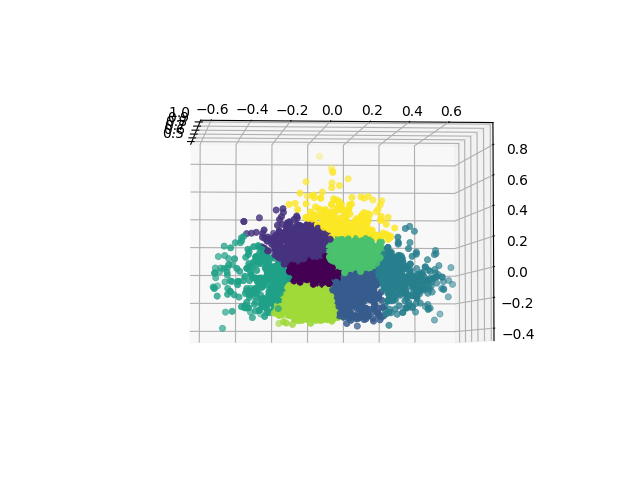

In [5]:
# Many genes we not expressed much, so we discard those. 
df = df[(df['sum_meanTPM_Ti'] > 1) & (df['sum_meanTPM_Tii'] > 1) & (df['sum_meanTPM_Tiii'] > 1) & (df['sum_meanTPM_Tiv'] > 1)]

# We normalize the data with 'l2' normalization.
# This makes the sum of the squares of each feature equal to one.
normalized_df = preprocessing.normalize(df, norm = 'l2')

# Create a object that can perform the singular vector decomposition
svd = TruncatedSVD(n_components=3)

# We perform the singular vector decomposition.
# This results in a 3 dimensional data set.
reduced = svd.fit_transform(normalized_df)

# Converting the result to a dataframe.
reduced_df = pd.DataFrame(data=reduced, columns = ["x", "y", "z"])

# My man Kartik Krishnan says that 8 clusters are where its at.
pred = KMeans(n_clusters = 8).fit_predict(reduced_df)

# Lets plot it. We color based off the color. 
x = reduced_df["x"]
y = reduced_df["y"]
z = reduced_df["z"]
r = pred

ax = plt.axes(projection='3d') 
ax.scatter(x, y, z, c=r, cmap='viridis', linewidth=0.5);
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

## Contents of each cluster. 

Each one of these clusters should represent genes that follow similar expression curves. We should check to make sure that is the case.

In [7]:
# We gotta tidy up our dataframe to make these plots work. 
# This will take a hot second to run. Its cool. Grab some coffee or something. 

df['cluster'] = pred

tidy_df = pd.DataFrame(columns=['tp','cluster','mean_TPM'])

for index, row in df.iterrows():
    mean_TPMs = row[0:4]
    # mean_TPMs = (mean_TPMs - mean_TPMs.min()) / (mean_TPMs.max() - mean_TPMs.min())    
    tidy_df = tidy_df.append({ 'tp':0, 'cluster':row[4], 'mean_TPM':mean_TPMs[0]}, ignore_index = True)
    tidy_df = tidy_df.append({ 'tp':1, 'cluster':row[4], 'mean_TPM':mean_TPMs[1]}, ignore_index = True)
    tidy_df = tidy_df.append({ 'tp':2, 'cluster':row[4], 'mean_TPM':mean_TPMs[2]}, ignore_index = True)
    tidy_df = tidy_df.append({ 'tp':3, 'cluster':row[4], 'mean_TPM':mean_TPMs[3]}, ignore_index = True)
    
tidy_df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,tp,cluster,mean_TPM
0,0.0,6.0,13.196876
1,1.0,6.0,7.264274
2,2.0,6.0,10.564025
3,3.0,6.0,18.017042
4,0.0,0.0,53.034548
...,...,...,...
24055,3.0,0.0,9.594415
24056,0.0,6.0,54.530993
24057,1.0,6.0,25.342858
24058,2.0,6.0,39.206475


<IPython.core.display.Javascript object>


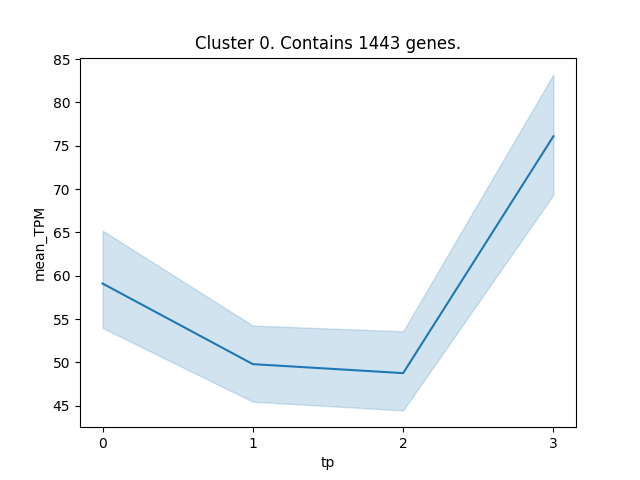

<IPython.core.display.Javascript object>


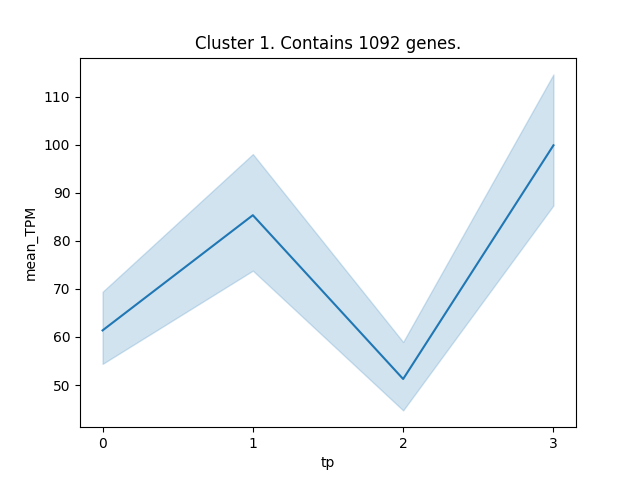

<IPython.core.display.Javascript object>


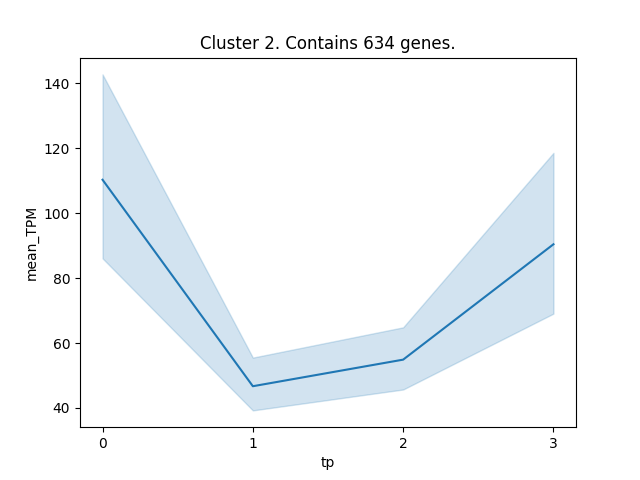

<IPython.core.display.Javascript object>


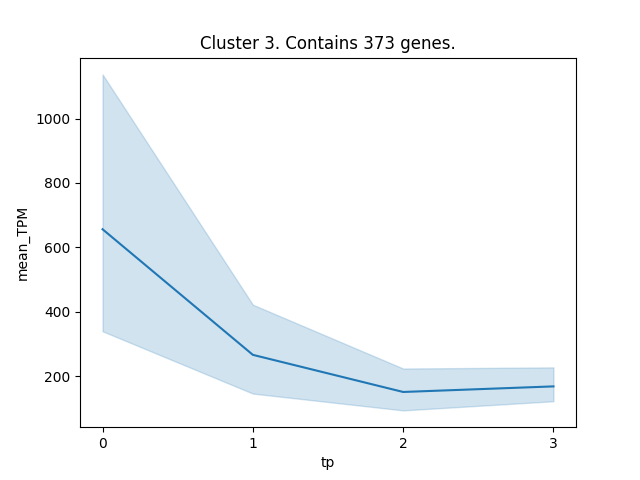

<IPython.core.display.Javascript object>


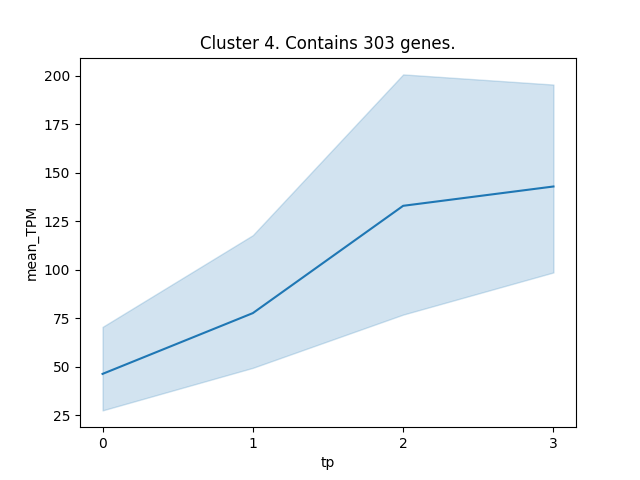

<IPython.core.display.Javascript object>


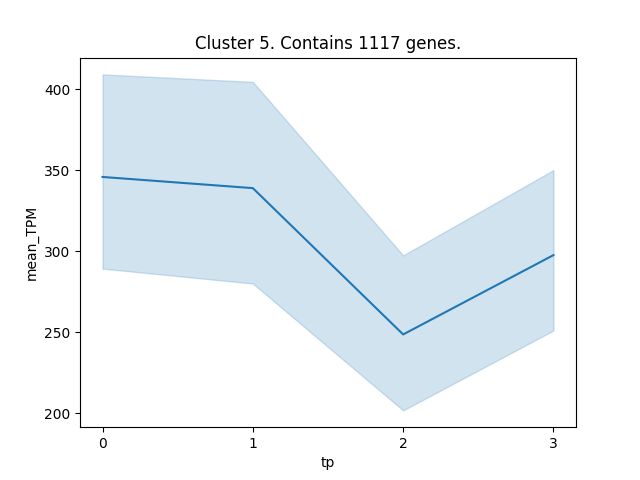

<IPython.core.display.Javascript object>


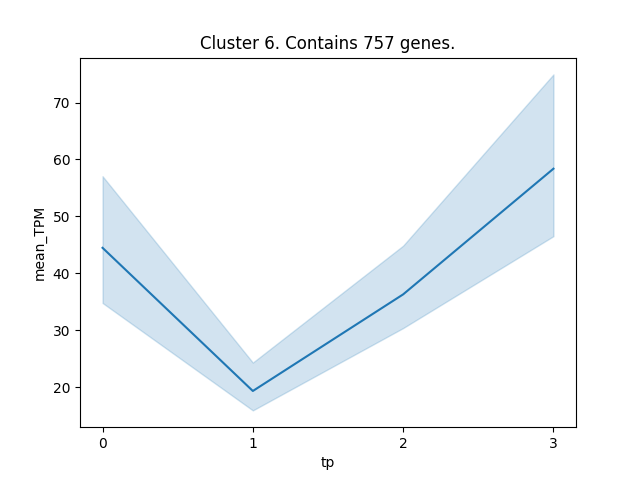

<IPython.core.display.Javascript object>


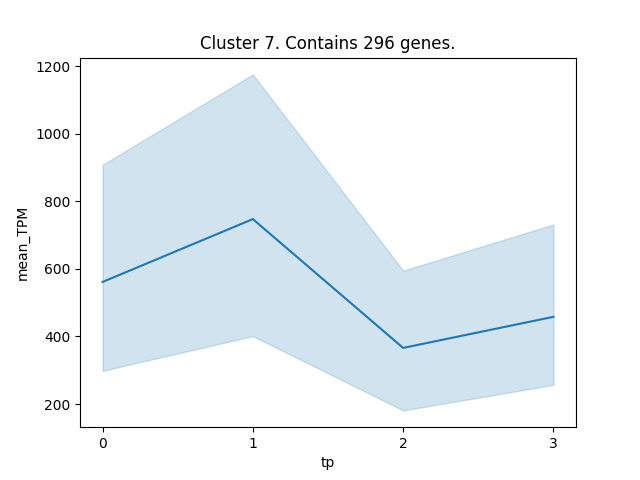

In [11]:
# Plot each clusters genes.

for i in range(8):
    plt.figure()
    cluster_df = tidy_df[tidy_df.cluster == i]
    ax = sns.lineplot(x="tp", y="mean_TPM", data=cluster_df)
    ax.set_title('Cluster ' + str(i) + '. Contains ' + str(int(cluster_df.shape[0]/4)) + ' genes.')
    ax.set_xticks([0,1,2,3])